In [82]:
import os
import pandas as pd
import numpy as np
import random
import itertools
import timeit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Download Data from OpenML https://www.openml.org/d/37
df_diabetes = pd.read_csv('pima_diabetes.csv')
print("Diabetes shape: ",df_diabetes.shape)

# Download Data from OpenML https://www.openml.org/d/37
df_wine_data = pd.read_csv('wine-quality-red.csv')
print("Wine data shape: ",df_wine_data.shape)

Diabetes shape:  (768, 9)
Wine data shape:  (1599, 12)


In [85]:
# For diabetes data
diabetes_map = {'tested_positive' : 1, 'tested_negative' : 0}
df_diabetes['class'] = df_diabetes['class'].map(diabetes_map)

# For wine data
def quality(q):
    if q == 3:
        return 0
    elif q == 4:
        return 1
    elif q == 5:
        return 2
    elif q == 6:
        return 3
    elif q == 7:
        return 4
    else:
        return 5

df_wine_data['class'] = df_wine_data['class'].apply(quality)

In [86]:
df_wine_data.head(5)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  class  
0      9.4      2  
1      9.8      2  
2      9.8      2  
3      9.8      3  
4      9.4      2

In [87]:
wine_percent = df_wine_data['class'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print(30*"-")
print("Wine class distribution:")
print(wine_percent)

------------------------------
Wine class distribution:
2    42.6%
3    39.9%
4    12.4%
1     3.3%
5     1.1%
0     0.6%
Name: class, dtype: object


class                   1.000000
alcohol                 0.476166
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total_sulfur_dioxide   -0.185100
volatile_acidity       -0.390558
Name: class, dtype: float64

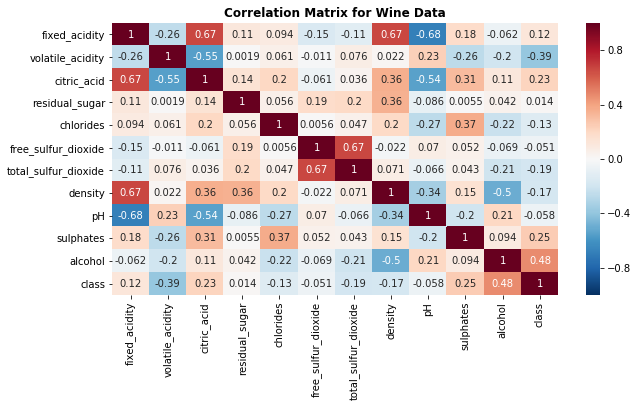

In [88]:
# Correlation between the target variable and predictor variables
correlation = df_wine_data.corr()
plt.figure(figsize=(10, 5))
plt.title("Correlation Matrix for Wine Data", fontsize=12, fontweight='bold')
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
fname = 'Correlation_Wine.jpg'
plt.savefig(fname)


correlation['class'].sort_values(ascending=False)

# Helper functions

In [89]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neural_network import MLPClassifier
from scipy.stats import mode

def import_data():
    X1 = StandardScaler().fit_transform(np.array(df_diabetes.iloc[:,:-1].values))
    Y1 = np.array(df_diabetes.iloc[:,-1].values)
    X2 = StandardScaler().fit_transform(np.array(df_wine_data.iloc[:,:-1].values))
    Y2 = np.array(df_wine_data.iloc[:,-1].values)
    return X1,Y1,X2,Y2

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        pred[mask] = mode(Y[mask])[0]
    '''pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)  '''  
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [90]:
X1,Y1,X2,Y2=import_data()
print(X1.shape)
print(X2.shape)

(768, 8)
(1599, 11)


In [91]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(np.array(X2),np.array(Y2), test_size=0.20, random_state = 0)
clf = DummyClassifier(strategy='most_frequent', random_state=20)
clf.fit(X2_train, Y2_train)
print(clf.score(X2_test, Y2_test))

0.421875


In [92]:
# K Means clustering and EM
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, homogeneity_score, completeness_score, silhouette_samples, v_measure_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [93]:
def run_kmeans(X,y,title, n = 30, file=''):

    kclusters = list(np.arange(2,n))
    sil_scores = []; c_scores = []; homo_scores = []; train_times = []
    Sum_of_squared_distances = []; v_scores =[]

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=20,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        kc_labels = km.predict(X)
        sil_scores.append(sil_score(X, kc_labels))
        c_scores.append(completeness_score(y, kc_labels))
        homo_scores.append(homogeneity_score(y, kc_labels))
        v_scores.append(v_measure_score(y, kc_labels))
        Sum_of_squared_distances.append(km.inertia_)
        
        
    # curve for silhouette score
    print(v_scores)
    fig = plt.figure()
    fig.set_size_inches(6, 4)
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Silhoutte vs No. of clusters')
    fname = 'Sil_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
   
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores, color="r", label="Homogeneity Scores")
    ax.plot(kclusters, c_scores, color="g", label="Completeness Scores")
    plt.grid(True)
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('Scores vs number of clusters')
    plt.legend(loc="best")
    fname = 'Score_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
    
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.plot(kclusters, Sum_of_squared_distances)
    plt.grid(True)
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    fname = 'SS_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()

def evaluate_kmeans(km, X, y, title=''):
    start_time = timeit.default_timer()
    km.fit(X)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)    
    accuracy = accuracy_score(y, y_mode_vote)
    
    print("Model Evaluation Metrics Using Mode Cluster Vote: "+title)
    print("***********************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))      
    print("V Measure Score: {:.2f}".format(v_measure_score(y, km.labels_))) 
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("***********************************************************")
    plt.figure()
    plt.show()

[0.03706780710981358, 0.0550198068551895, 0.058414705165979575, 0.09493135240102792, 0.09066575120755174, 0.10151519504476904, 0.09684384738106047, 0.10237008913748648, 0.09587585828475649, 0.09574804401125149]


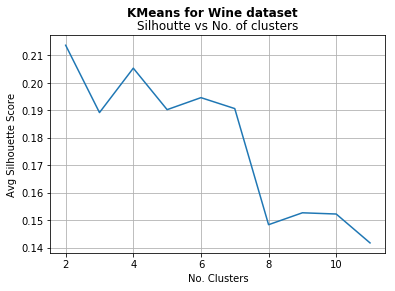

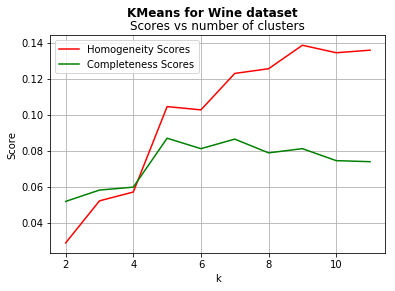

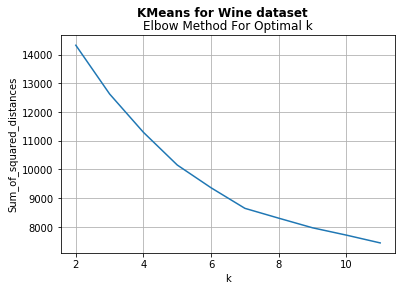

In [94]:
run_kmeans(X2,Y2,title='KMeans for Wine dataset', n =12, file = "Km_W")

In [95]:
km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=20, copy_x=True, n_jobs=None, algorithm='auto')
evaluate_kmeans(km,X2,Y2, title ="Kmeans-Wine")
km = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=20, copy_x=True, n_jobs=None, algorithm='auto')
evaluate_kmeans(km,X2,Y2, title ="Kmeans-Wine")

Model Evaluation Metrics Using Mode Cluster Vote: Kmeans-Wine
***********************************************************
Model Training Time (s):   0.09
No. Iterations to Converge: 24
V Measure Score: 0.09
Accuracy:  0.55
***********************************************************


<Figure size 432x288 with 0 Axes>

Model Evaluation Metrics Using Mode Cluster Vote: Kmeans-Wine
***********************************************************
Model Training Time (s):   0.09
No. Iterations to Converge: 15
V Measure Score: 0.10
Accuracy:  0.56
***********************************************************


<Figure size 432x288 with 0 Axes>

## PCA, ICA, RCA, RCF

In [96]:
# PCA
from sklearn.decomposition import PCA, FastICA as FICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import LinearSVC
from sklearn import metrics
from itertools import product
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import SelectFromModel


def run_PCA(x,y,title='',file=""):
    
    pca = PCA(random_state=20).fit(x) #for all components
    print(pca.explained_variance_)
    '''n_samples = x.shape[0]
    X_centered = x - np.mean(x, axis=0)
    cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
    eigenvalues=(pca.explained_variance_)
    for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
        print("Eigen vector:\n",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
        print("Eigenvalues:\n",eigenvalue)'''
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(cum_var))), cum_var, 'g-', label='cumulative variance ratio')
    ax1.set_xlabel('Principal Components')    
    ax1.set_ylabel('Cumulative Explained Variance', color='g')
    ax1.tick_params('y', colors='g')
    plt.legend(loc="lower left")
    plt.grid(False)
    plt.axhline(y = .90, color='b', linestyle='--', label = '90% Explained Variance')
    #plt.axhline(y = .85, color='c', linestyle='--', label = '95% Explained Variance')

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'r-',label='Singular values')
    ax2.set_ylabel('Singular values', color='r')
    ax2.tick_params('y', colors='r')
    plt.grid(False)

    plt.title("PCA Explained Variance and Singular values: "+ title)
    fig.tight_layout()
    plt.legend(loc="lower right")
    fname = 'PCA_Variance'+file+'.jpg'
    plt.savefig(fname)
    plt.show()   
    
    
def run_ICA(x,y,title='',file=""):
        dims = list(np.arange(2,(x.shape[1]),1))
        print(dims)
        ica = FICA(random_state=20)
       
        kurt = []
        dims1=2

        tmp2 = ica.fit_transform(x)
        tmp2 = pd.DataFrame(tmp2)
        print(tmp2.head(20))
        #print(tmp2.kurt())
        tmp2.plot(rot=0,subplots=True,figsize=(20,20))
        #plt.figure()
        #tmp2.plot();
        plt.show()
        """
        for dim in dims:
            ica1 = FICA(random_state=20,n_components=dim)
            tmp1 = ica1.fit(x)
            print(tmp1.mixing_)
            print("Line")
        """ 

        for dim in dims:
            ica.set_params(n_components=dim)
            tmp = ica.fit_transform(x)

            tmp = pd.DataFrame(tmp)

            tmp = tmp.kurt(axis=0)
            #print(tmp.components_)
            kurt.append(tmp.abs().mean())

        plt.figure()
        plt.title("ICA Kurtosis: "+ title)
        plt.xlabel("Number of Independent Components")
        plt.ylabel("Avg Kurtosis Across IC")
        plt.plot(dims, kurt, 'b-')
        plt.grid(False)
        fname = 'ICA_Kurtosis'+file+'.jpg'
        plt.savefig(fname)
        plt.show()

def run_RCA(x,y,title='Pima indians dataset',file=''):    
    dims = list(np.arange(1,(x.shape[1]),1))
    tmp = defaultdict(dict)
    tt = []
    xtrain,xtest, ytrain, ytest = train_test_split(np.array(x),np.array(y), test_size=0.20, random_state =0)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)        
        d1 = pairwise_distances(rp.fit_transform(x))
        d2 = pairwise_distances(x)
        #d3 = pairwise_distances(d1,d2)
        coef = np.corrcoef(d1.ravel(),d2.ravel())[0,1]    
        tmp[dim][i] = coef
         
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()
    
    for dim in dims:
        rp = RCA(random_state=20, n_components=dim)
        model = LinearSVC(random_state=20)
        model.fit(rp.fit_transform(xtrain), ytrain)
        test = rp.transform(xtest)
        tt.append(metrics.accuracy_score(model.predict(test), ytest))
        
    fig, ax1 = plt.subplots()
    #ax1.plot(dims,tt, 'b-', label='Accuracy', color='b', linestyle='--') 
    ax1.plot(dims,mean_recon, 'g-', label='Mean Reconstruction Correlation')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='g')
    ax1.tick_params('y', colors='g')
    ax1.legend(loc="best")
    plt.grid(False)
   
    ax2 = ax1.twinx()
    #ax2.plot(dims,std_recon, 'r-', label='STD Reconstruction Correlation')
    #ax2.set_ylabel('STD Reconstruction Correlation', color='r')
    ax2.plot(dims,tt, 'r-', label='Accuracy', color='r')    
    ax2.set_ylabel('Accuracy Score', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc="best")
    plt.grid(False)

    plt.title("Mean reconstruction correlation/accuracy of components "+ title)
    plt.legend(loc="best")
    fig.tight_layout()
    fname = 'RCA_Mean'+file+'.jpg'
    plt.savefig(fname)    
    plt.show()
    
def run_RFC(x,y,df_original,title='',file=""):
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    rfc.fit(x,y)
    imp = rfc.feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[:-1])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.90]
    selected_cols = imp.index.tolist()
    important_features = rfc.feature_importances_ 
    indices = np.argsort(important_features)[::-1]
    df_original.columns[:-1]
    plt.bar(indices, important_features[indices])
    plt.xticks(range(x.shape[1]), df_original.columns[:-1], rotation =90)    
    plt.xlabel('feature index')
    plt.ylabel('importance value')
    plt.title('RFC importance: '+title)
    fname = 'RFC_features'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    print('imp ', imp)
    print('selected_cols ', selected_cols)
    return imp, selected_cols

# Clusters visualization after PCA in k means

In [97]:
def run_PCA_Kmeans(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    pca = PCA(6)#.fit(x) #for all components
    principalComponents = pca.fit_transform(X_std)
    
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

    
    #figure(4)
    #https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com
    #print(x[0])
    nComp = 3
    Xhat = np.dot(pca.transform(x)[:,:nComp], pca.components_[:nComp,:])
    mu = np.mean(x, axis=0)
    Xhat += mu
    #print(Xhat[0])

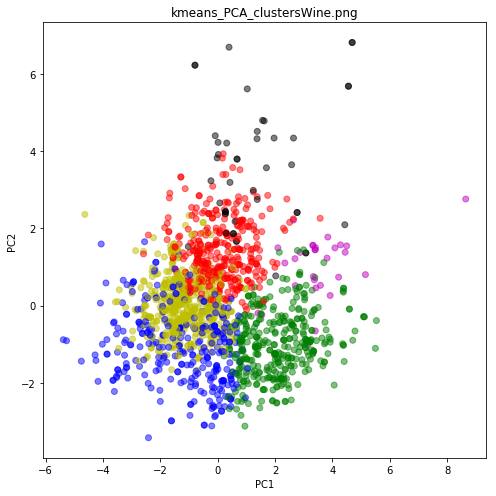

In [98]:
run_PCA_Kmeans(X2,Y2,(0,1,2,3,4,5),6,title='kmeans_PCA_clustersWine.png')

In [99]:
def run_ICA_Kmeans(x,y,zipval,k,title):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    ica = FICA(n_components = 8,random_state=20)#.fit(x) #for all components
    principalComponents = ica.fit_transform(X_std)
    
    # Save components to a DataFrame
    ICA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,5],principalComponents[:,6], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('IC6')
    plt.ylabel('IC7')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()


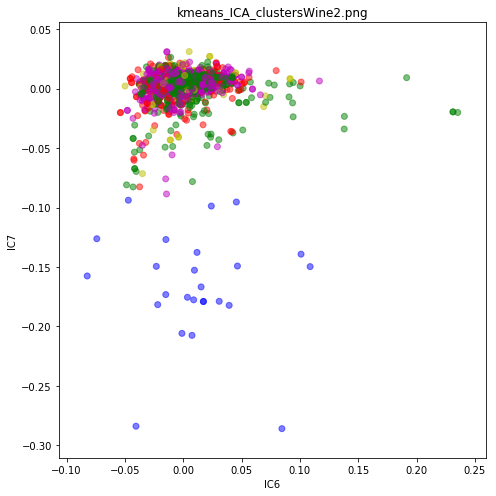

In [100]:
run_ICA_Kmeans(X2,Y2,(0,1,2,3,4,5),5,title='kmeans_ICA_clustersWine2.png')

In [101]:
def run_RCA_Kmeans(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rca = RCA(random_state=20,n_components=d)#.fit(x) #for all components
    principalComponents = rca.fit_transform(X_std)
    
    # Save components to a DataFrame
    RCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,7],principalComponents[:,8], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('RP8')
    plt.ylabel('RP9')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()


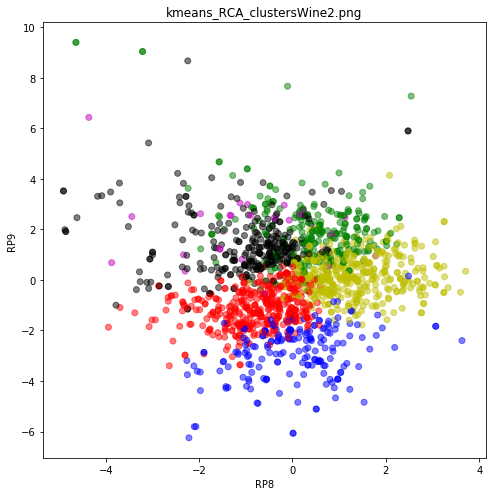

In [102]:
run_RCA_Kmeans(X2,Y2,(0,1,2,3,4,5),6,'kmeans_RCA_clustersWine2.png',9)

In [103]:
def run_RFC_Kmeans(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    fitdata=rfc.fit(x,y)
    #print(fitdata.get_params)
    best_features=rfc.feature_importances_
    print(best_features)
    bestFeature=np.argmax(best_features)
    # Save components to a DataFrame
    #RFC_components = pd.Dataframe(principalComponents)
    features_req=d
    topF=[]
    sorted_features=np.copy(best_features)
    sorted_features.sort()#sorting array
    sorted_features=sorted_features[::-1]#making it descending
    for i in range(features_req):
        topF.append(best_features.tolist().index(sorted_features[i]))
    newX = x[:,topF]
    newX=pd.DataFrame(newX)
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)#kmeans for diabetes
    #learner = KMeans(rfc)
    #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(newX)
    #print(X_clustered)
    #accuracy = accuracy_score(y,X_clustered)
    #print("Accuracy:  "+"{:.2f}".format(accuracy))
    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    #print(topF)
    plt.figure(figsize = (6,4))
    plt.scatter(x[:,topF[0]],x[:,topF[1]], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('alcohol')
    plt.ylabel('sulphates')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

[0.0456717  0.11728201 0.05448634 0.03621393 0.05076509 0.04306548
 0.11392023 0.07944088 0.04080287 0.14537794 0.27297351]


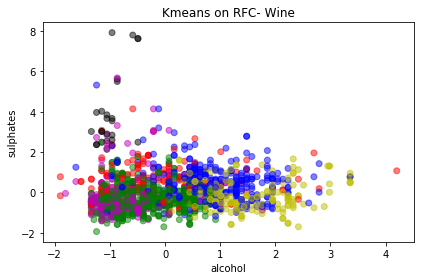

In [190]:
run_RFC_Kmeans(X2,Y2,(0,1,2,3,4,5),6,'Kmeans on RFC- Wine',8)

## PCA in EM

In [181]:
def run_PCA_EM(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    pca = PCA(6)#.fit(x) #for all components
    principalComponents = pca.fit_transform(X_std)
    
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

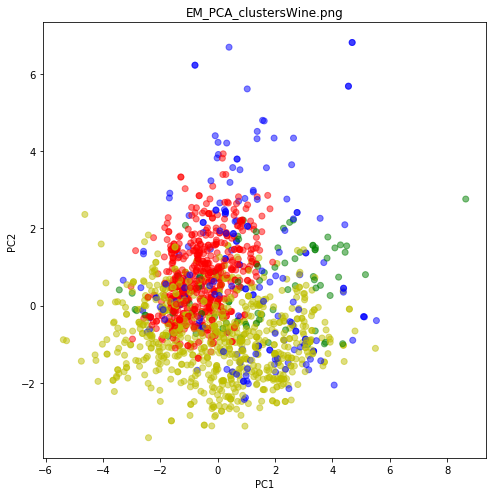

In [182]:
run_PCA_EM(X2,Y2,(0,1,2,3,4,5),4,title='EM_PCA_clustersWine.png')

In [183]:
def run_ICA_EM(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    ica = FICA(n_components =8,random_state=20)#.fit(x) #for all components
    principalComponents = ica.fit_transform(X_std)
    
    # Save components to a DataFrame
    ICA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,5],principalComponents[:,6], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('IC6')
    plt.ylabel('IC7')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

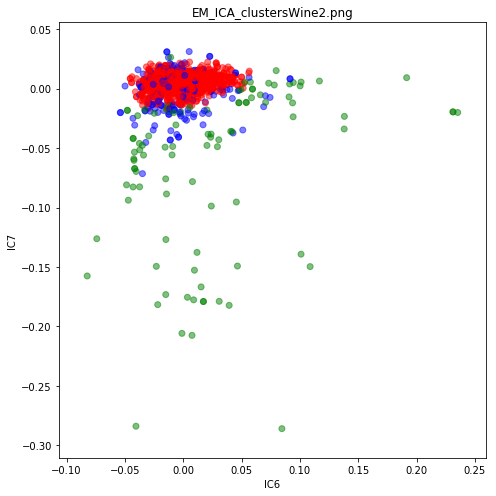

In [184]:
run_ICA_EM(X2,Y2,(0,1,2,3,4,5),3,title='EM_ICA_clustersWine2.png')

In [185]:
def run_RCA_EM(x,y,zipval,k,title,d):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rca = RCA(random_state=20,n_components=d)#.fit(x) #for all components
    principalComponents = rca.fit_transform(X_std)
    # Save components to a DataFrame
    RCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,7],principalComponents[:,8], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('RP8')
    plt.ylabel('RP9')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

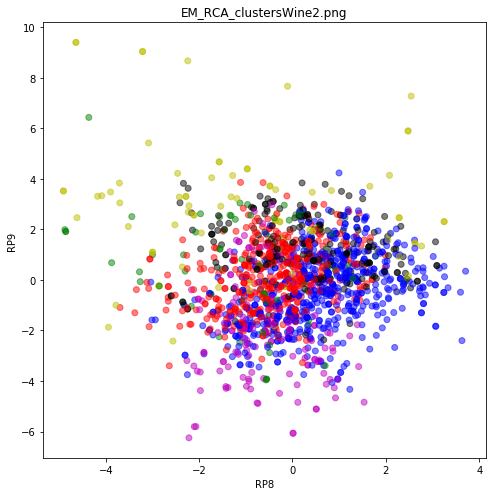

In [186]:
run_RCA_EM(X2,Y2,(0,1,2,3,4,5),6,'EM_RCA_clustersWine2.png',9)

In [187]:
def run_RFC_EM(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    fitdata=rfc.fit(x,y)
    #print(fitdata.get_params)
    best_features=rfc.feature_importances_
    print(best_features)
    bestFeature=np.argmax(best_features)
    # Save components to a DataFrame
    #RFC_components = pd.Dataframe(principalComponents)
    features_req=d
    topF=[]
    sorted_features=np.copy(best_features)
    sorted_features.sort()#sorting array
    sorted_features=sorted_features[::-1]#making it descending
    for i in range(features_req):
        topF.append(best_features.tolist().index(sorted_features[i]))
    newX = x[:,topF]
    newX=pd.DataFrame(newX)
        
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(newX)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    #print(topF)
    plt.figure(figsize = (6,4))
    plt.scatter(x[:,topF[0]],x[:,topF[1]], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('alcohol')
    plt.ylabel('sulphates')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

[0.0456717  0.11728201 0.05448634 0.03621393 0.05076509 0.04306548
 0.11392023 0.07944088 0.04080287 0.14537794 0.27297351]


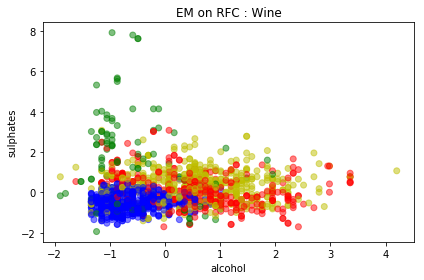

In [189]:
run_RFC_EM(X2,Y2,(0,1,2,3,4,5),4,'EM on RFC : Wine',8)

# Cluster vizualization with features for K means

In [113]:
def plotClustersHistogram(x,y,k1,dataset):
    random_seed = 7641
    kmeans=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans.fit(x)
    plt.figure()
   #Store the labels
    labels = kmeans.labels_

    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print(counts)
    #Output : [243 244 245]
    #print(kmeans.labels_)
    plt.hist(kmeans.labels_, bins=np.arange(0, k1 + 1) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, k1))
    plt.xlabel('Cluster label')
    plt.ylabel('Number of samples')
    plt.title(dataset)
    plt.grid()
    name='kmeans_hist_'+dataset+'.png'
    plt.savefig(name)
    
def plotClustersDiabetes(x,y):
    #for diabetes

    k1=4
    df1 = pd.read_csv('pima_diabetes.csv', nrows=1)
    to_drop = ['class']
    df1 = df1.drop(to_drop, axis=1)
    cols1 = df1.columns
    random_seed = 7641
    kmeans=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans.fit(x)
    df1 = pd.DataFrame(x, columns = cols1)
    df1['result'] = y
    df1['class'] = kmeans.labels_
    print(df1.head(5))

    # Parallel coordinates plot
    rand_idx1 = np.arange(0,8,1)#all features
    idx_viz1 = np.append(rand_idx1, [df1.shape[1] - 2, df1.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df1.iloc[:, idx_viz1], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Diabetes: k-means visualization')
    plt.tight_layout()
    plt.savefig('kmeans_viz_1.png')
    

def plotClustersWine(x,y):
      
    #for wine data
    k1=6
    df2 = pd.read_csv('wine-quality-red.csv', nrows=1)
    to_drop = ['class']
    df2 = df2.drop(to_drop, axis=1)
    cols2 = df2.columns
    random_seed = 7641
    kmeans2=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans2.fit(x)
    df2 = pd.DataFrame(x, columns = cols2)
    df2['result'] = y
    df2['class'] = kmeans2.labels_
    print(df2.head(5))

    # Parallel coordinates plot
    rand_idx2 = np.arange(0,11,1)#all 11 features
    #print(rand_idx2)
    idx_viz2 = np.append(rand_idx2, [df2.shape[1] - 2, df2.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df2.iloc[:, idx_viz2], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Wines: k-means visualization')
    plt.tight_layout()
    plt.savefig('kmeans_viz_2.png')
    

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  result  class  
0 -0.960246       2      0 

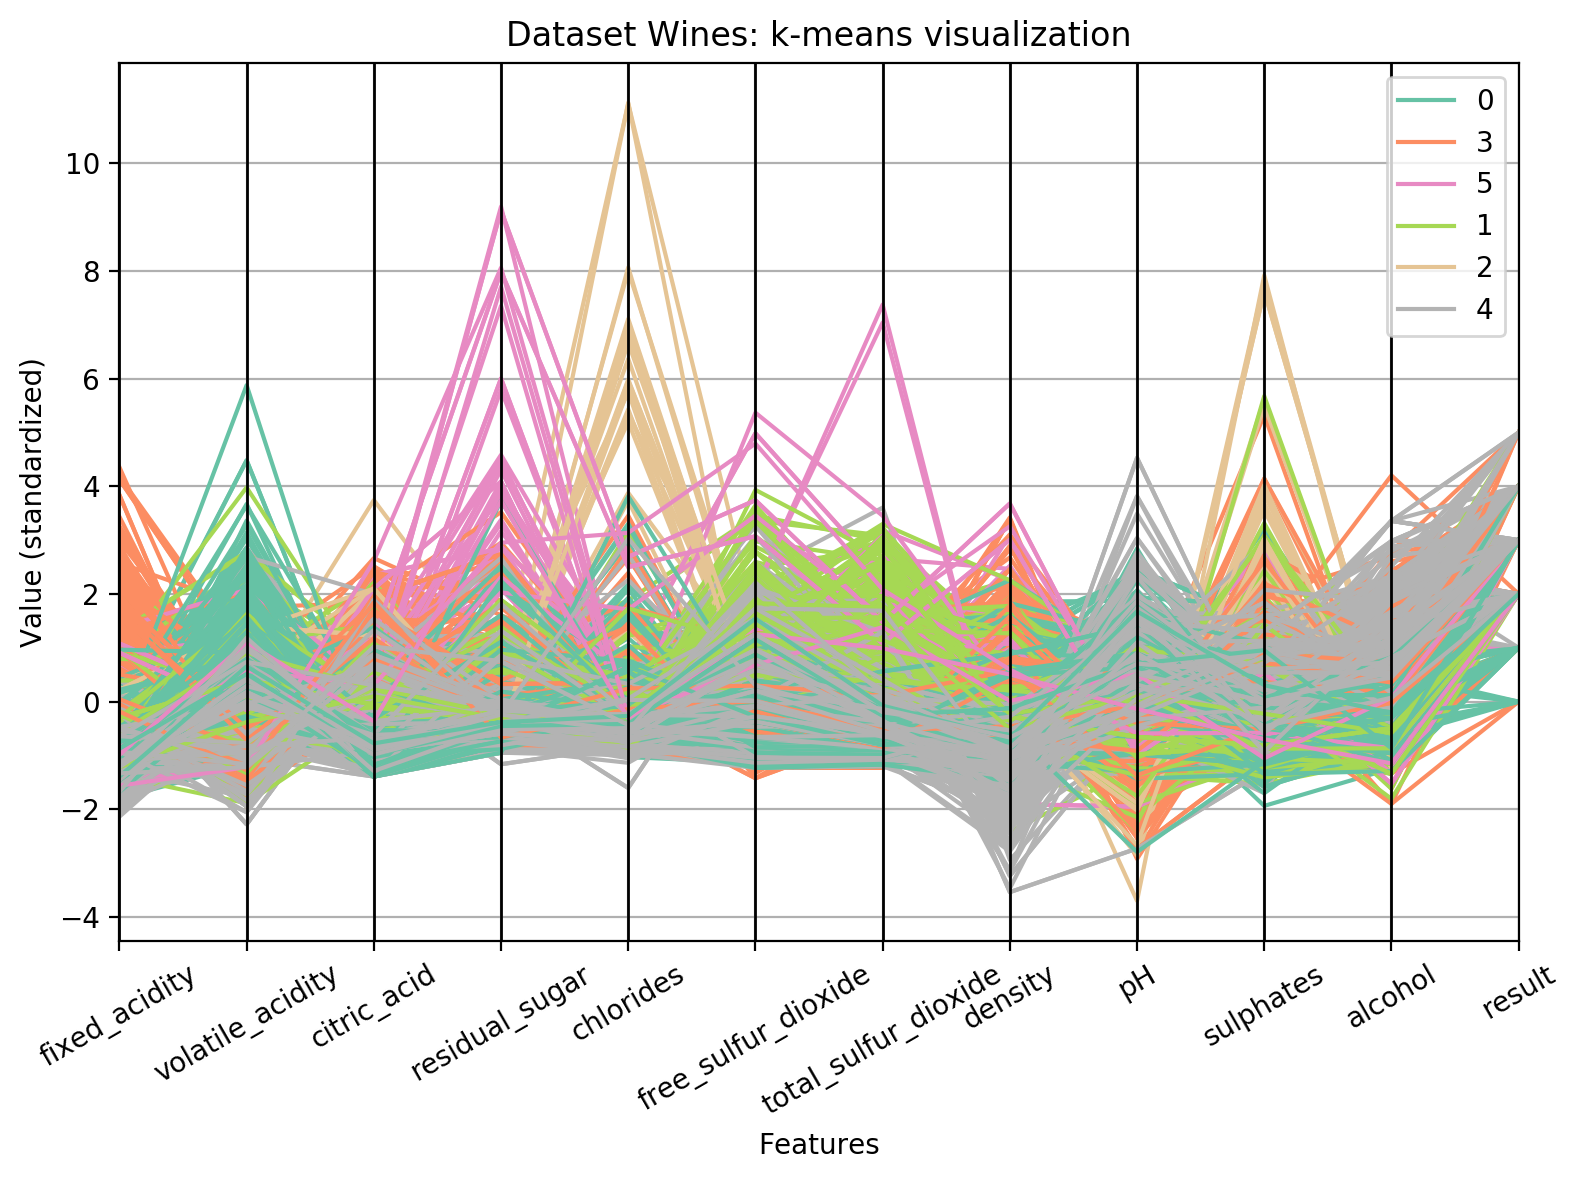

In [114]:
plotClustersWine(X2,Y2)

[527 332  28 363 303  46]


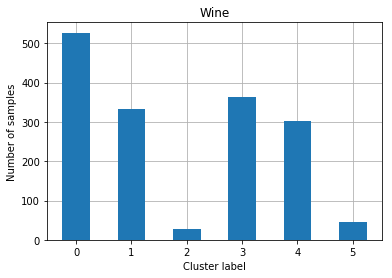

In [115]:
plotClustersHistogram(X2,Y2,6,'Wine')

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  result  class  
0 -0.960246       2      0 

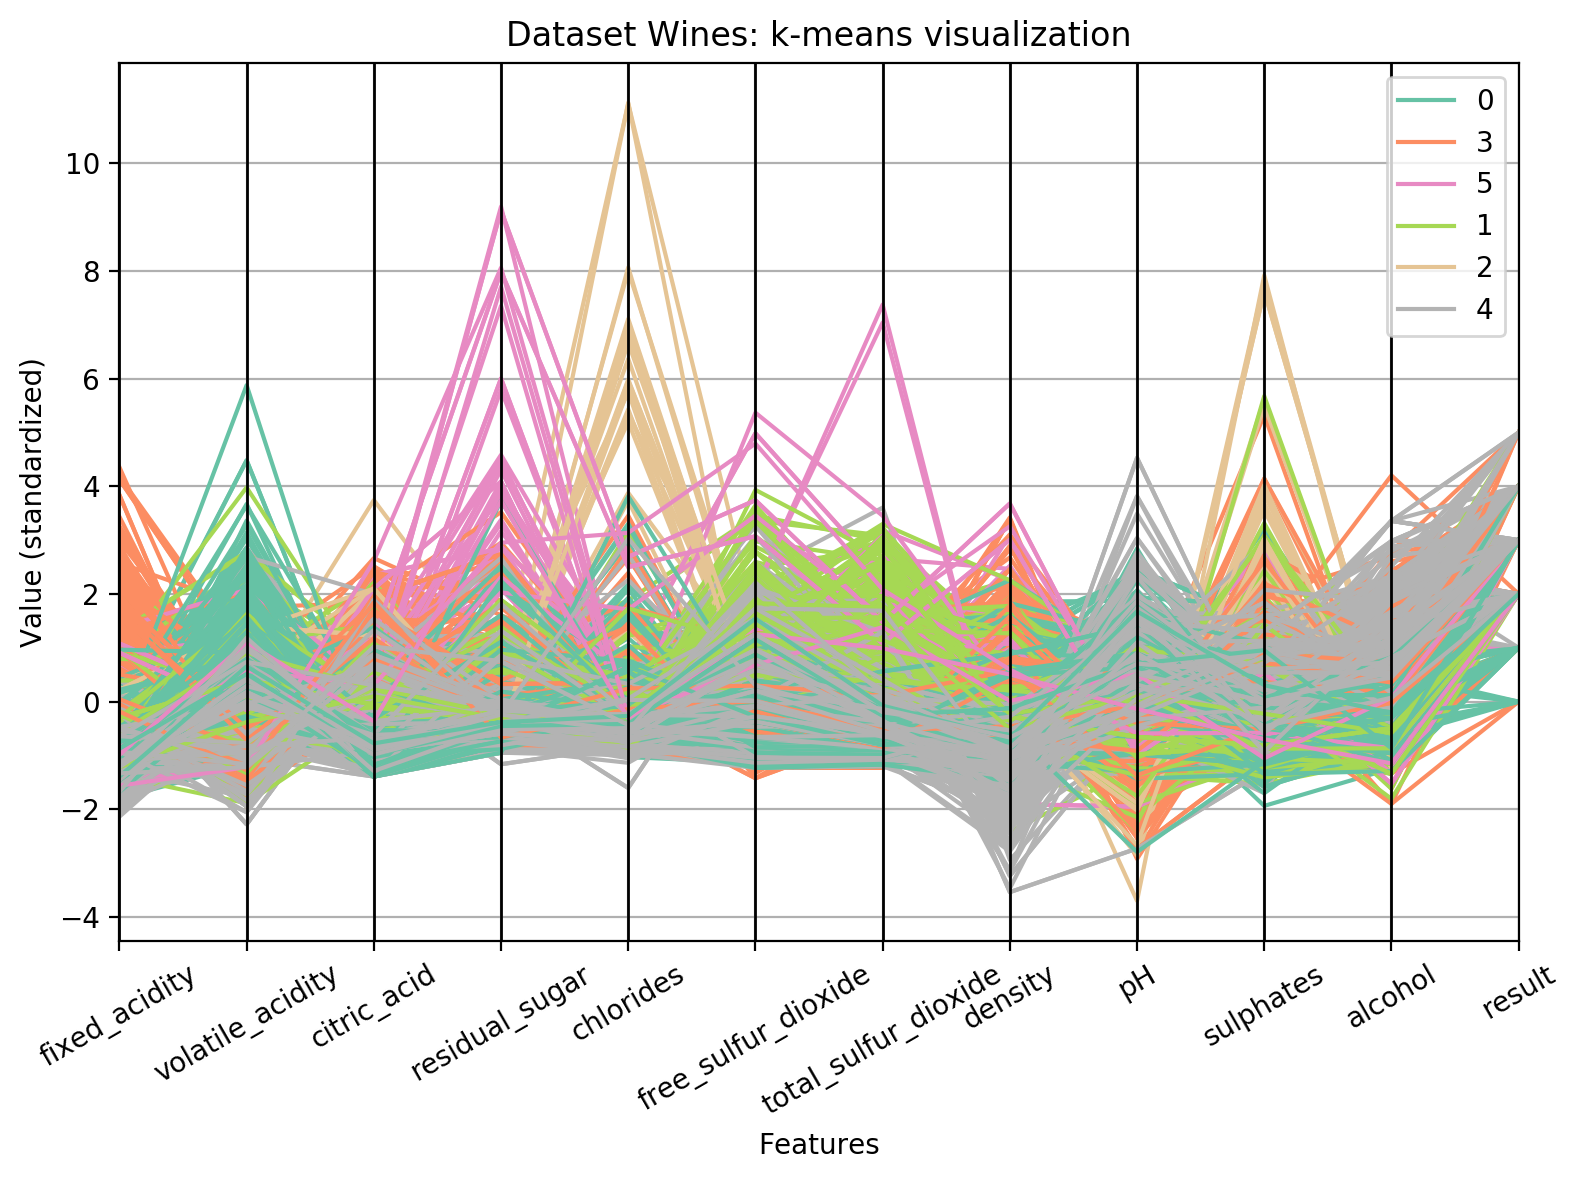

In [116]:
plotClustersWine(X2,Y2)

## Expectation Maximization 

  ## Cluster vizualization with features for EM¶

In [117]:
def plotEMHistogram(x,y,k1,dataset):
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    plt.figure()
   #Store the labels
    labels = em.predict(x)

    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print(counts)
    #Output : [243 244 245]
    #print(kmeans.labels_)
    plt.hist(labels, bins=np.arange(0, k1 + 1) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, k1))
    plt.xlabel('Cluster label')
    plt.ylabel('Number of samples')
    plt.title(dataset)
    plt.grid()
    name='em_hist_'+dataset+'.png'
    plt.savefig(name)
    
def plotEMDiabetes(x,y,k1):
    #for diabetes

    df1 = pd.read_csv('pima_diabetes.csv', nrows=1)
    to_drop = ['class']
    df1 = df1.drop(to_drop, axis=1)
    cols1 = df1.columns
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    labels = em.predict(x)
    df1 = pd.DataFrame(x, columns = cols1)
    df1['result'] = y
    df1['class'] = labels
    print(df1.head(5))

    # Parallel coordinates plot
    rand_idx1 = np.arange(0,8,1)#all features
    idx_viz1 = np.append(rand_idx1, [df1.shape[1] - 2, df1.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df1.iloc[:, idx_viz1], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Diabetes: EM visualization')
    plt.tight_layout()
    plt.savefig('Em_viz_1.png')
    

def plotEMWine(x,y,k1):
      
    #for wine data
    df2 = pd.read_csv('wine-quality-red.csv', nrows=1)
    to_drop = ['class']
    df2 = df2.drop(to_drop, axis=1)
    cols2 = df2.columns
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    labels = em.predict(x)
    df2 = pd.DataFrame(x, columns = cols2)
    df2['result'] = y
    df2['class'] = labels
    print(df2.head(5))

    # Parallel coordinates plot
    rand_idx2 = np.arange(0,11,1)#all 11 features
    #print(rand_idx2)
    idx_viz2 = np.append(rand_idx2, [df2.shape[1] - 2, df2.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df2.iloc[:, idx_viz2], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Wines: EM visualization')
    plt.tight_layout()
    plt.savefig('Em_viz_2.png')

[419 235 403 149  86 307]


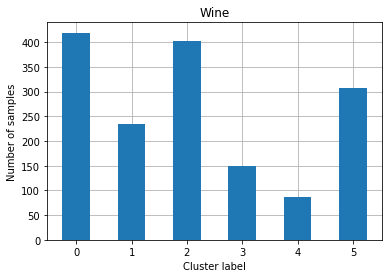

In [118]:
plotEMHistogram(X2,Y2,6,'Wine')

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  result  class  
0 -0.960246       2      0 

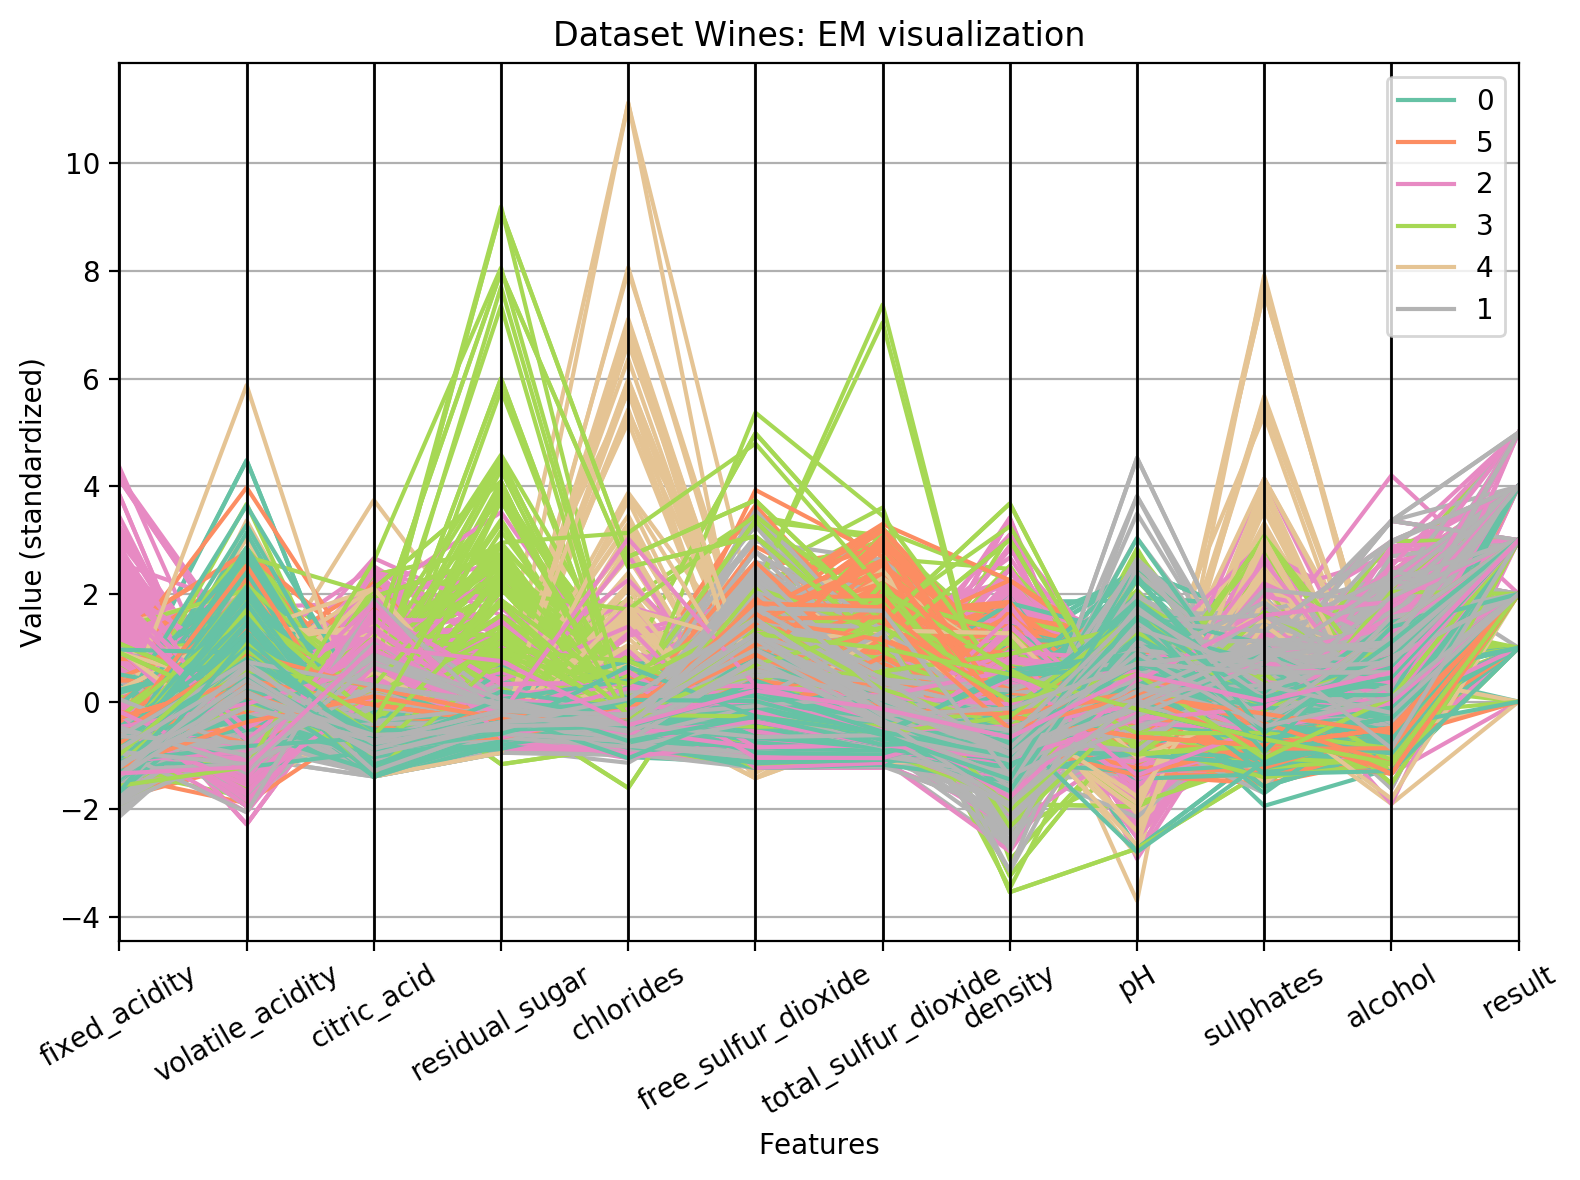

In [119]:
plotEMWine(X2,Y2,6)

# EM program

In [120]:
def run_EM(X,y,title,n=30,file=''):

    kdist = list(np.arange(2,n))
    sil_scores = []; c_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []; v_scores=[]
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
        end_time = timeit.default_timer()
        em.fit(X)
        train_times.append(end_time - start_time)
        em_labels = em.predict(X)
        sil_scores.append(sil_score(X, em_labels))
        c_scores.append(completeness_score(y, em_labels))
        homo_scores.append(homogeneity_score(y, em_labels))
        v_scores.append(v_measure_score(y, em_labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # curve for silhouette score
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Silhoutte vs No. of clusters')
    fname = 'Sil_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
   
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores, color="r", label="Homogeneity Scores")
    ax.plot(kdist, c_scores, color="g", label="Completeness Scores")
    #ax.plot(kdist, v_scores, color="b", label="V Measure Scores")
    plt.grid(True)
    plt.xlabel('number of components')
    plt.ylabel('Score')
    plt.title('Scores vs number of components')
    plt.legend(loc="best")
    fname = 'Score_'+file+'.jpg'
    plt.savefig(fname)
    plt.show() 

    # plot model AIC and BIC
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, (aic_scores), label='AIC')
    ax.plot(kdist, (bic_scores),label='BIC')
    #ax.plot(kdist, np.gradient(aic_scores), label='Gradient AIC')
    #ax.plot(kdist, np.gradient(bic_scores),label='Gradient BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('BIC vs number of components')
    plt.legend(loc="best")
    fname = 'BIC_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
    
def evaluate_EM(em, X, y, title = ''):
    start_time = timeit.default_timer()
    em.fit(X)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)    
    accuracy = accuracy_score(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote: "+title)
    print("****************************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("V Measure Score: {:.2f}".format(v_measure_score(y, labels)))  
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    
    print("****************************************************************")
    plt.figure()
    plt.show()

In [121]:
em = EM(n_components=5, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=20, 
                     warm_start=False, verbose=0, verbose_interval=10)
evaluate_EM(em,X2,Y2,title = "EM-Diabetes")
em = EM(n_components=6, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=20, 
                     warm_start=False, verbose=0, verbose_interval=10)
evaluate_EM(em,X2,Y2,title = "EM-Diabetes")

Model Evaluation Metrics Using Mode Cluster Vote: EM-Diabetes
****************************************************************
Model Training Time (s):   0.09
No. Iterations to Converge: 34
Log-likelihood Lower Bound: -9.97
V Measure Score: 0.08
Accuracy:  0.53
****************************************************************


<Figure size 432x288 with 0 Axes>

Model Evaluation Metrics Using Mode Cluster Vote: EM-Diabetes
****************************************************************
Model Training Time (s):   0.06
No. Iterations to Converge: 19
Log-likelihood Lower Bound: -9.81
V Measure Score: 0.09
Accuracy:  0.54
****************************************************************


<Figure size 432x288 with 0 Axes>

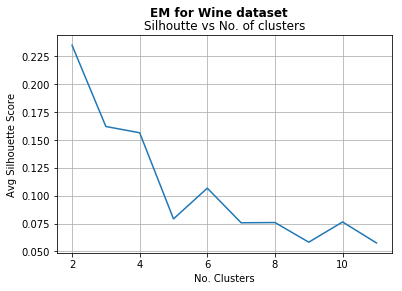

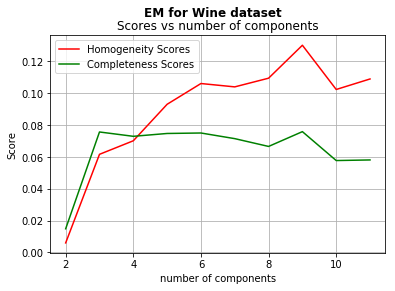

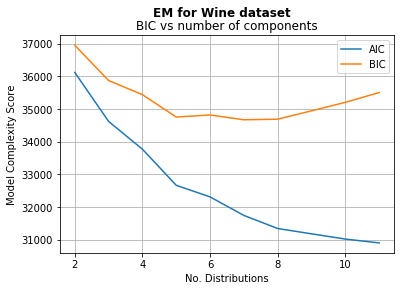

In [122]:
run_EM(X2,Y2,n=12,title='EM for Wine dataset', file="EM_W")

In [123]:
import seaborn as sns
def plot_ICA_Wine(x,y):
        result = pd.DataFrame()
        result['class']=y
        ica = FICA(random_state=20)
        data = ica.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='r', label = '3')
            sns.distplot(data[i][result['class']==1], color='g', label = '4')
            sns.distplot(data[i][result['class']==2], color='b', label = '5')
            sns.distplot(data[i][result['class']==3], color='c', label = '6')
            sns.distplot(data[i][result['class']==4], color='y', label = '7')
            sns.distplot(data[i][result['class']==5], color='k', label = '8')
            plt.legend(loc='best')
        fig.suptitle('Wine')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('ICA_Wine_KurtosisPlots.png')
        plt.show()

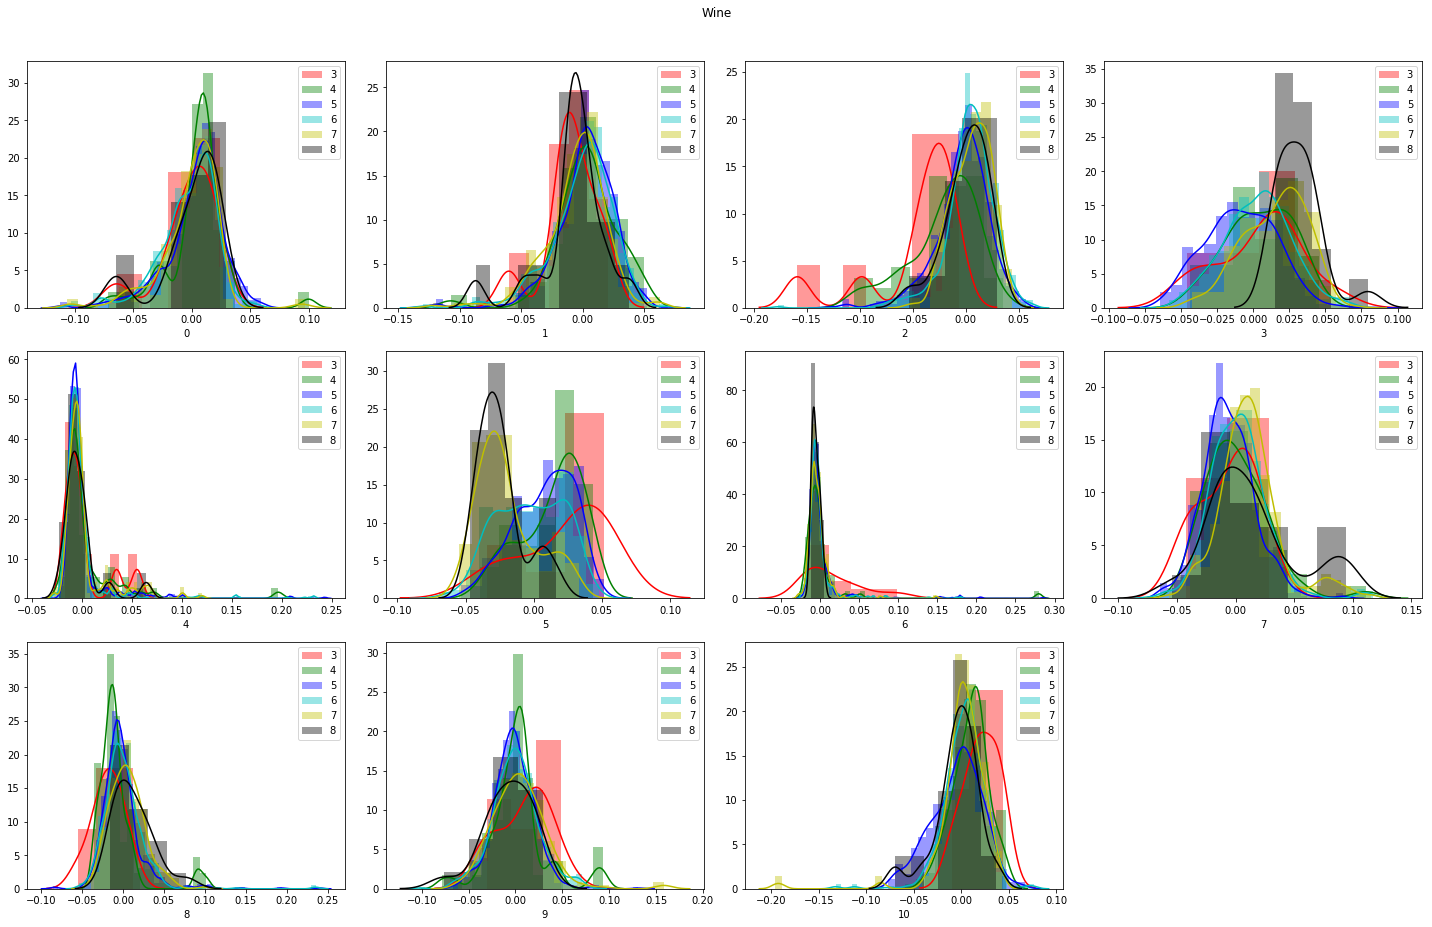

In [124]:
plot_ICA_Wine(X2,Y2)

In [125]:
def plot_PCA_wine(x,y,title='',file=""):
        result = pd.DataFrame()
        result['class']=y
        pca = PCA(random_state=20)
        data = pca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='r', label = '3')
            sns.distplot(data[i][result['class']==1], color='g', label = '4')
            sns.distplot(data[i][result['class']==2], color='b', label = '5')
            sns.distplot(data[i][result['class']==3], color='c', label = '6')
            sns.distplot(data[i][result['class']==4], color='y', label = '7')
            sns.distplot(data[i][result['class']==5], color='k', label = '8')
            plt.legend(loc='best')
        fig.suptitle('Wine')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('PCA_Wine_KurtosisPlots.png')

        plt.show()

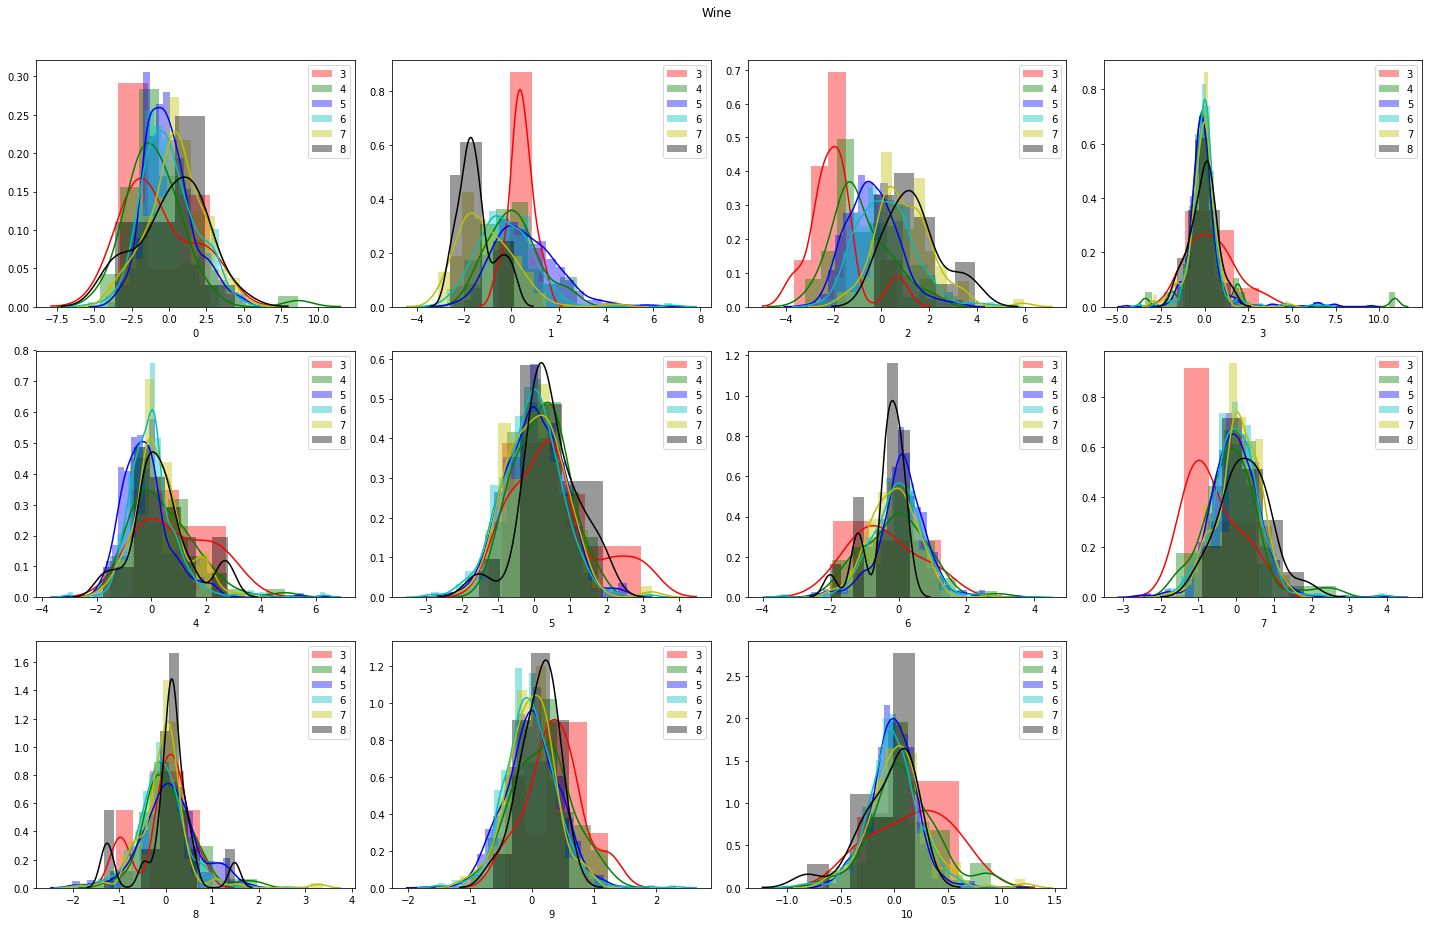

In [126]:
plot_PCA_wine(X2,Y2,title = "Wine dataset",file= "D")

In [127]:
from sklearn import (random_projection)
def plot_RCA_wine(x,y):
        result = pd.DataFrame()
        result['class']=y
        rca = RCA(random_state=20,n_components=11)
        data = rca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='r', label = '3')
            sns.distplot(data[i][result['class']==1], color='g', label = '4')
            sns.distplot(data[i][result['class']==2], color='b', label = '5')
            sns.distplot(data[i][result['class']==3], color='c', label = '6')
            sns.distplot(data[i][result['class']==4], color='y', label = '7')
            sns.distplot(data[i][result['class']==5], color='k', label = '8')
            plt.legend(loc='best')
        fig.suptitle('Wine')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('RCA_Wine_KurtosisPlots.png')
        plt.show()
        

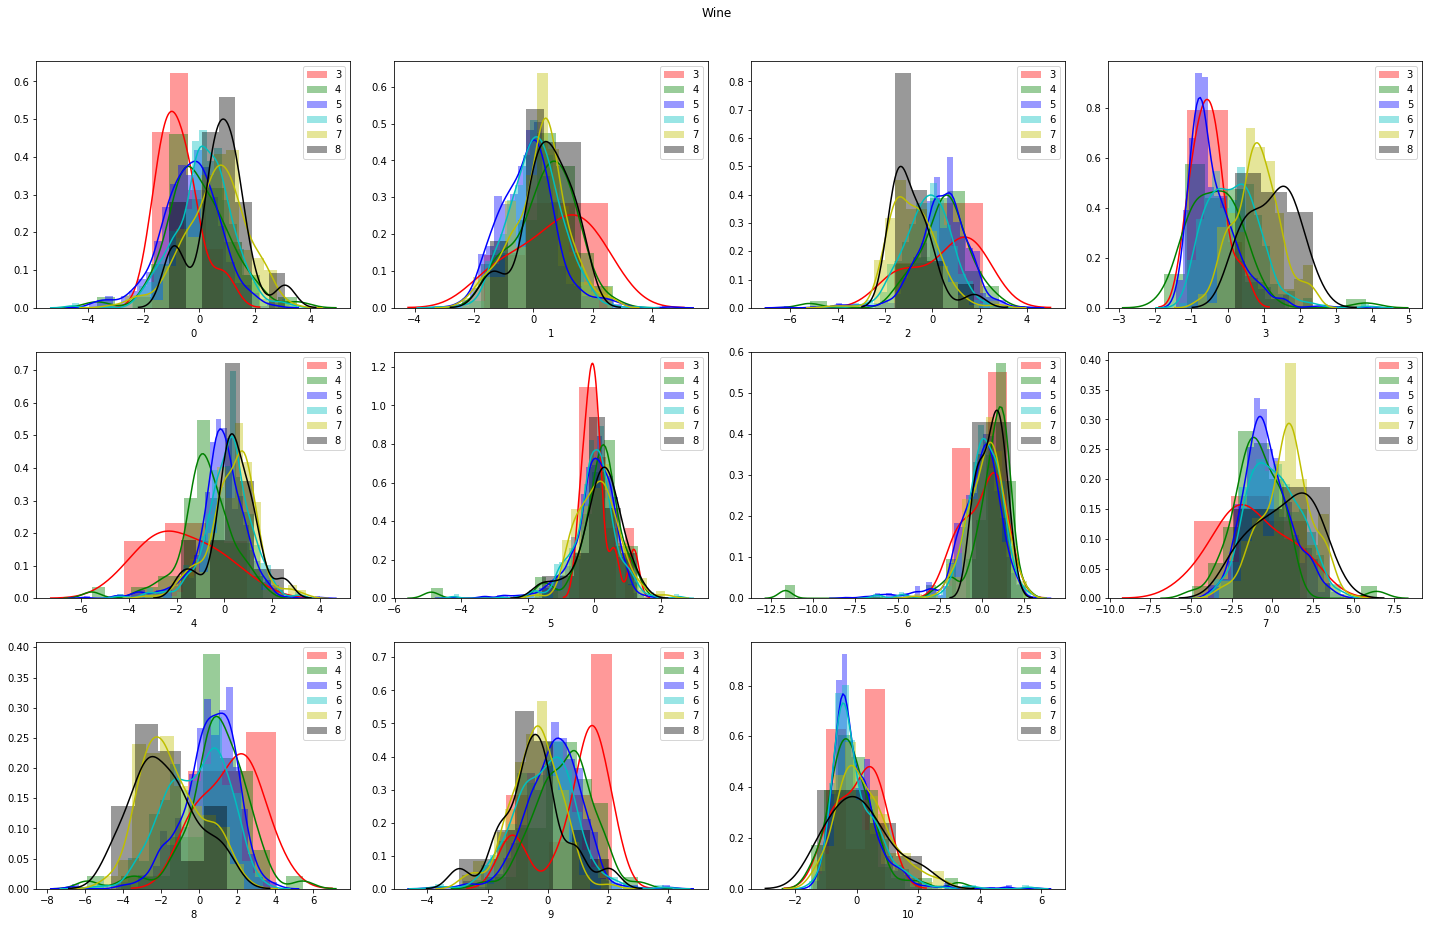

In [128]:
plot_RCA_wine(X2,Y2)

In [129]:
def plot_DataKurt_wine(x,y):
        result = pd.DataFrame()
        result['class']=y
        #rca = RCA(random_state=20,n_components=8)
        data =x# rca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='r', label = '3')
            sns.distplot(data[i][result['class']==1], color='g', label = '4')
            sns.distplot(data[i][result['class']==2], color='b', label = '5')
            sns.distplot(data[i][result['class']==3], color='c', label = '6')
            sns.distplot(data[i][result['class']==4], color='y', label = '7')
            sns.distplot(data[i][result['class']==5], color='k', label = '8')
            plt.legend(loc='best')
        fig.suptitle('Wine')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('Data_Wine_KurtosisPlots.png')
        plt.show()

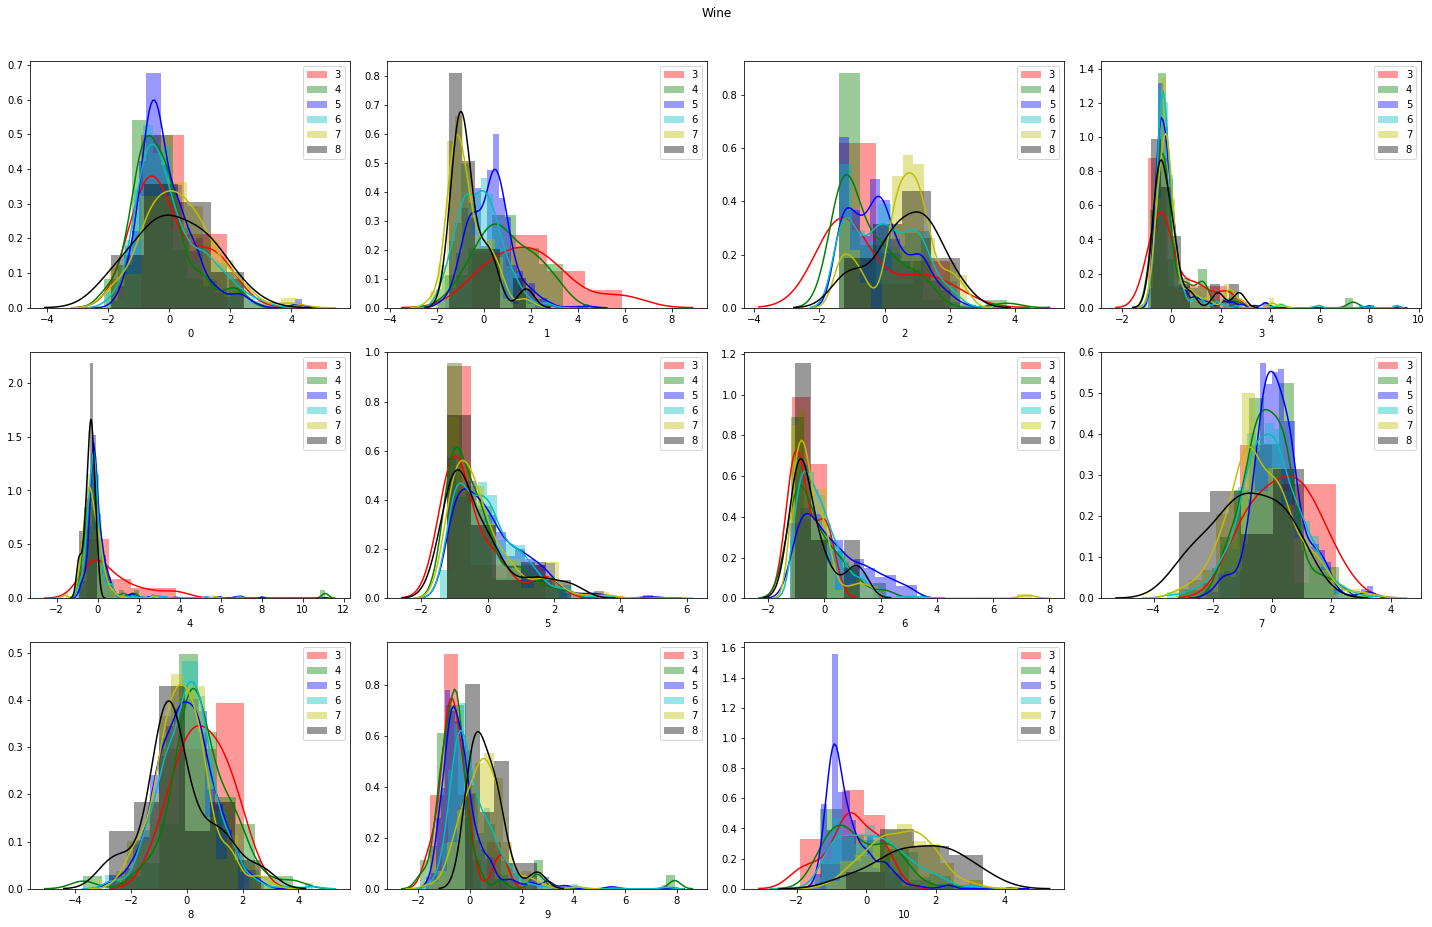

In [130]:
plot_DataKurt_wine(X2,Y2)

[3.10107182 1.92711489 1.55151379 1.21399175 0.95989238 0.66002104
 0.58415655 0.42322138 0.34485779 0.18144664 0.05959558]


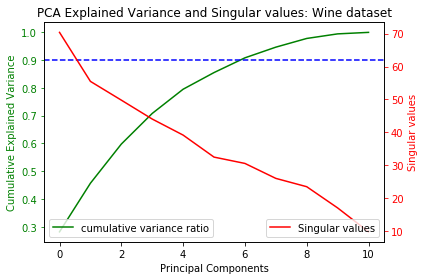

[2, 3, 4, 5, 6, 7, 8, 9, 10]
          0         1         2         3         4         5         6   \
0   0.004453  0.001575 -0.001561 -0.024107 -0.011104  0.034659 -0.009520   
1  -0.021381 -0.012029 -0.014937  0.020625 -0.001354  0.047832  0.002238   
2   0.003869 -0.008267 -0.001380  0.009444 -0.006246  0.039627 -0.000359   
3   0.005520  0.002423  0.007045 -0.025967 -0.010575 -0.032698 -0.007650   
4   0.004453  0.001575 -0.001561 -0.024107 -0.011104  0.034659 -0.009520   
5   0.001960  0.001455  0.005373 -0.028468 -0.013367  0.034097 -0.010114   
6   0.010186  0.013296  0.011130 -0.009039 -0.014271  0.031047 -0.011088   
7  -0.013924  0.033235 -0.009417  0.016772 -0.014182  0.024375 -0.008076   
8   0.004027  0.017177  0.015998  0.002033 -0.004553  0.029296 -0.008798   
9   0.037715 -0.004355 -0.005635 -0.021496  0.062623 -0.005267 -0.011191   
10  0.017097  0.025597  0.014287 -0.006854 -0.008494  0.028954  0.005106   
11  0.037715 -0.004355 -0.005635 -0.021496  0.062623 -0.005

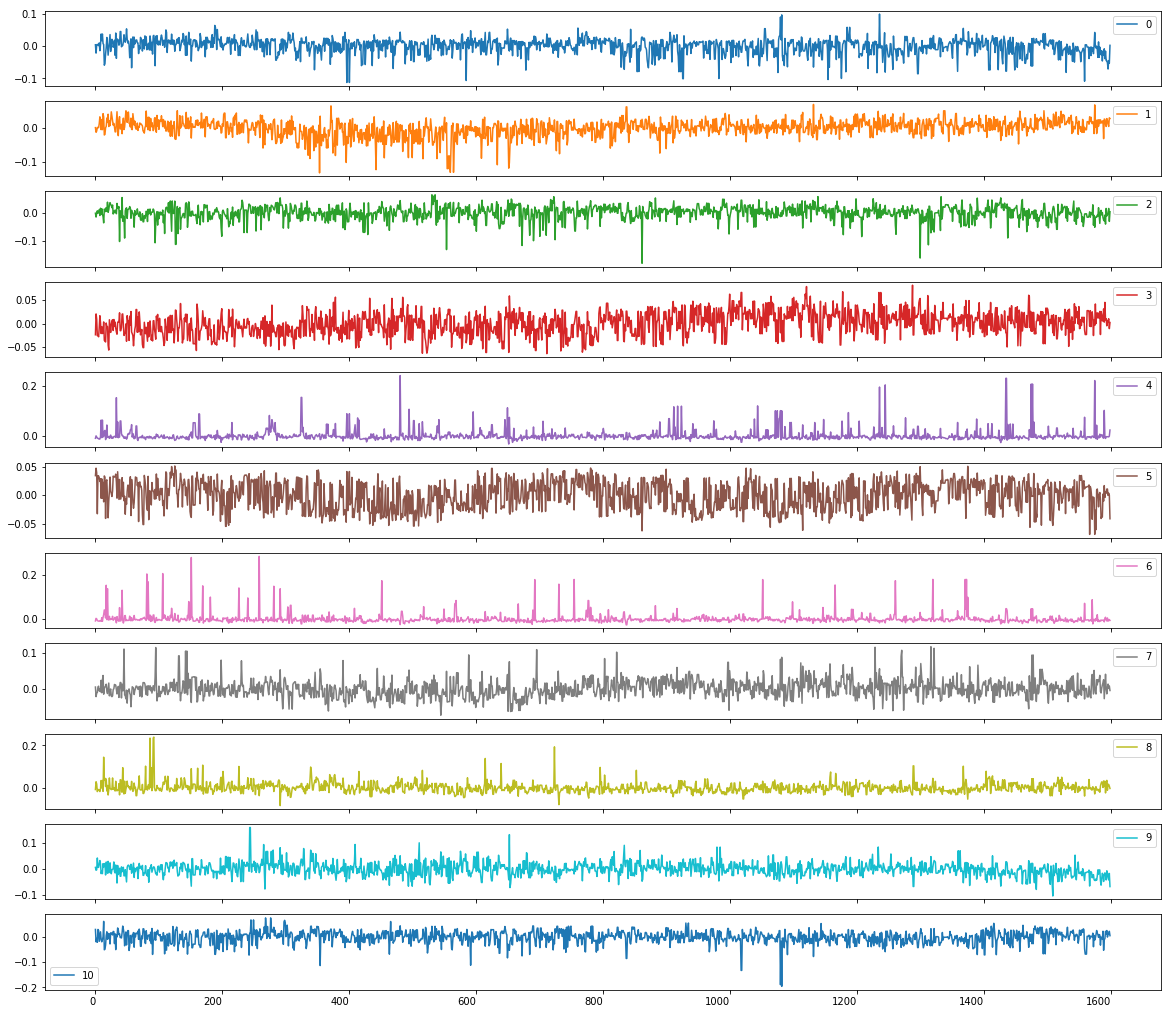

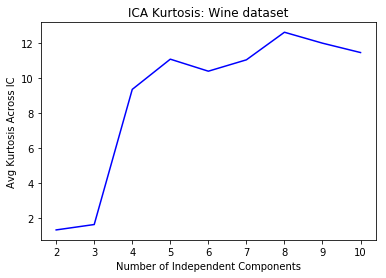

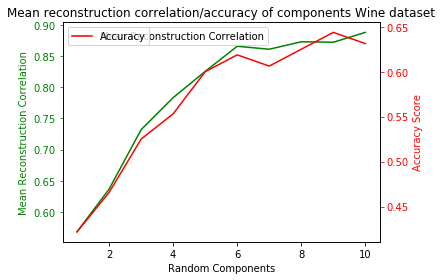

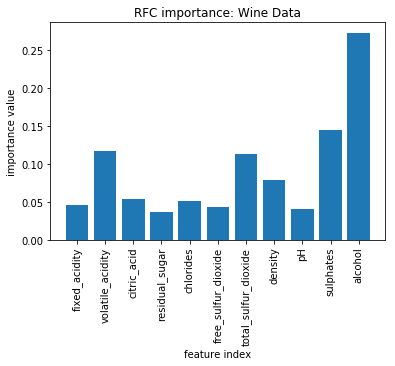

imp                        Feature Importance   Cum Sum
alcohol                         0.272974  0.272974
sulphates                       0.145378  0.418351
volatile_acidity                0.117282  0.535633
total_sulfur_dioxide            0.113920  0.649554
density                         0.079441  0.728995
citric_acid                     0.054486  0.783481
chlorides                       0.050765  0.834246
fixed_acidity                   0.045672  0.879918
selected_cols  ['alcohol', 'sulphates', 'volatile_acidity', 'total_sulfur_dioxide', 'density', 'citric_acid', 'chlorides', 'fixed_acidity']


In [131]:
run_PCA(X2,Y2,title = "Wine dataset", file= "W")
run_ICA(X2,Y2,title = "Wine dataset", file= "W")
run_RCA(X2,Y2,title = "Wine dataset", file= "W")
cumsum_features2, selected_features2 = run_RFC(X2,Y2,df_wine_data,title='Wine Data', file ="W")

In [132]:
pca_dia = PCA(n_components=5,random_state=5).fit_transform(X2)
ica_dia = FICA(n_components=6,random_state=5).fit_transform(X2)
rca_dia = RCA(n_components=5,random_state=5).fit_transform(X2)
rfc_dia = df_wine_data[selected_features2]
rfc_dia = np.array(rfc_dia.values)

## Error after reconstruction

In [133]:
from numpy import linalg as LA
from sklearn import metrics
def recons_error(x,y,n,dataset,opt=""):
    #https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
    #https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        if(opt=="PCA"):
            algo = PCA(n_components=i, random_state=42)
            
        if(opt=="ICA"):
            algo=FICA(random_state=42)
            algo.set_params(n_components=(i+1))
        if(opt=="RCA"):
            algo=RCA(n_components=(i+1), random_state=42)
        algo_results = algo.fit_transform(x)
        #print(algo.mean_.shape)
        #print(algo_results.shape)
        algo_proj_back=algo.inverse_transform(algo_results)
        total_loss=LA.norm((x-algo_proj_back),None)
        #total_loss=((x-algo_proj_back)**2).mean()

        loss=total_loss
        print("Error with "+str(i)+" "+opt+" "+str(loss))
        error_record.append(total_loss)

    plt.clf()
    plt.figure(figsize=(3,3))
    title=opt+ " reconstruction error: "+dataset
    plt.title(title)
    plt.plot(error_record,'r')
    plt.xticks(range(len(error_record)), range(start,max_comp), rotation='vertical')
    plt.xlim([-1, len(error_record)])
    title=title+".png"
    figName=opt+"_ReconsErr_"+dataset+".png"
    plt.savefig(figName)
    plt.show()

from numpy.testing import assert_array_almost_equal
from numpy.linalg import inv
import pandas as pd
def error_RCA(x,y,k,dataset,opt,n):
    #https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
    #https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        algo=RCA(n_components=(i+1), random_state=40)
        algo_results = algo.fit_transform(x)
        algo_proj_back=algo_results*algo.components_+algo_results.mean()
        total_loss=LA.norm((x-algo_proj_back),None)
        #total_loss=((x-algo_proj_back)**2).mean()
        loss=total_loss
        print("Error with "+str(i)+" "+opt+" "+str(loss))
        error_record.append(total_loss)
        
    plt.clf()
    plt.figure(figsize=(10,10))
    title=opt+ " reconstruction error: "+dataset
    plt.title(title)
    plt.plot(error_record,'r')
    plt.xticks(range(len(error_record)), range(start,max_comp), rotation='vertical')
    plt.xlim([-1, len(error_record)])
    title=title+".png"
    figName=opt+"_ReconsErr_"+dataset+".png"
    plt.savefig(figName)
    plt.show()
    
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
    
def error_RCA2(x,y,k,dataset,opt,n):    
# Modified Locally linear embedding of the digits dataset
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        
        
        algo=RCA(n_components=(i+1), random_state=42)
        #algo_results = algo.fit_transform(x)
        print("Computing modified LLE embedding")
        #clf = RCA(n_neighbors, n_components=2,

        X_projected = algo.fit_transform(x)
        plot_embedding(X_projected, "Random Projection of the digits")

        #print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    
    




Error with 0 RCA 371.81001577777954
Error with 1 RCA 335.82630937840435
Error with 2 RCA 193.57920224595892
Error with 3 RCA 189.6269935537725
Error with 4 RCA 215.60504754441172
Error with 5 RCA 150.21726159441465
Error with 6 RCA 178.01395027501667
Error with 7 RCA 168.53501562566984
Error with 8 RCA 135.94735814554042
Error with 9 RCA 106.81342052282072
Error with 10 RCA 97.10112845692967
Error with 11 RCA 112.16067151031784
Error with 12 RCA 121.17047261343667
Error with 13 RCA 109.37358995118207
Error with 14 RCA 125.25932890463025
Error with 15 RCA 115.82669356271872
Error with 16 RCA 97.56019720454415
Error with 17 RCA 123.65123333378651
Error with 18 RCA 86.8114947143334
Error with 19 RCA 95.97936331622914
Error with 20 RCA 93.15358134529514
Error with 21 RCA 107.2460964991111
Error with 22 RCA 82.52721565876017
Error with 23 RCA 82.71252578160782
Error with 24 RCA 71.97234488418098
Error with 25 RCA 75.88701111523432
Error with 26 RCA 73.10998805743793
Error with 27 RCA 72.923

<Figure size 432x288 with 0 Axes>

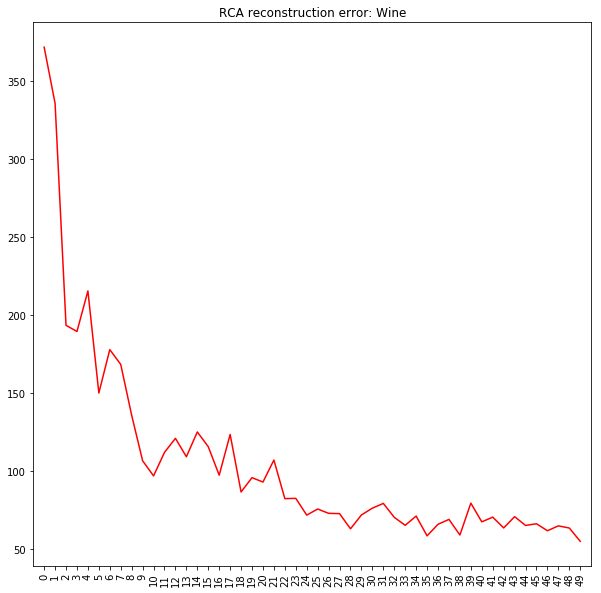

In [134]:
error_RCA(X2, Y2, 4,"Wine","RCA",50)

Error with 0 PCA 132.62352732452865
Error with 1 PCA 112.39878659206593
Error with 2 PCA 97.74434834656488
Error with 3 PCA 84.11087084999014
Error with 4 PCA 71.65667993110617
Error with 5 PCA 60.006430960912404
Error with 6 PCA 50.45847937800533
Error with 7 PCA 40.15689208157801
Error with 8 PCA 30.598500272046035
Error with 9 PCA 19.62614261909897
Error with 10 PCA 9.758777626481756


<Figure size 432x288 with 0 Axes>

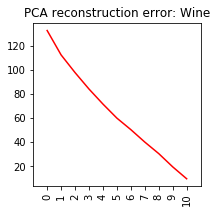

Error with 0 ICA 112.39878659206592
Error with 1 ICA 97.74434834656488
Error with 2 ICA 84.11087084999015
Error with 3 ICA 71.65667993110617
Error with 4 ICA 60.00643096091241
Error with 5 ICA 50.45847937800533
Error with 6 ICA 40.15689208157801
Error with 7 ICA 30.598500272046035
Error with 8 ICA 19.62614261909897
Error with 9 ICA 9.758777626481756
Error with 10 ICA 1.250792278813087e-13


<Figure size 432x288 with 0 Axes>

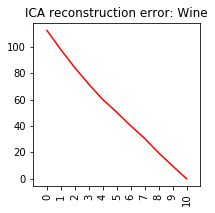

In [135]:
recons_error (X2,Y2,11,"Wine","PCA")
recons_error (X2,Y2,11,"Wine","ICA")

In [136]:
pca_wine = PCA(n_components=6,random_state=5).fit_transform(X2)
ica_wine = FICA(n_components=8,random_state=5).fit_transform(X2)
rca_wine = RCA(n_components=5,random_state=5).fit_transform(X2)
rfc_wine = df_wine_data[selected_features2]
rfc_wine = np.array(rfc_wine.values)              

[0.037005557761687465, 0.0519053759235944, 0.057731175545675265, 0.09289374175561618, 0.09079378614955963, 0.09764837706952684, 0.1046140546956324, 0.1028275767096709, 0.10370420382219016, 0.10393952467096572]


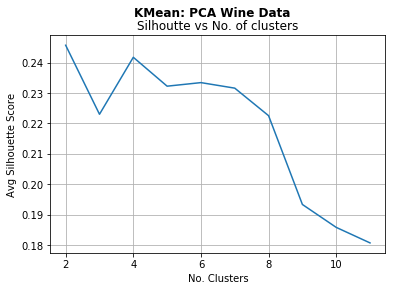

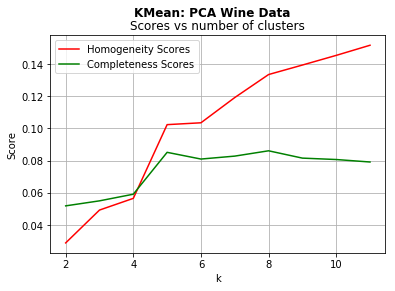

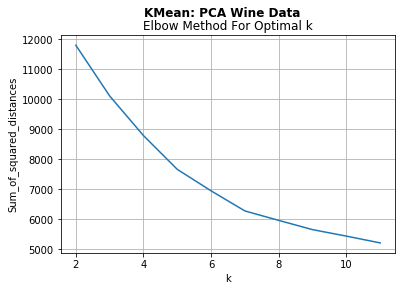

[0.09479952282614713, 0.0677734116198804, 0.06555710439354923, 0.1082972140360956, 0.09269604029407637, 0.09441732756099745, 0.09307579862606973, 0.08926066793177062, 0.0990954768659328, 0.09500474317434653]


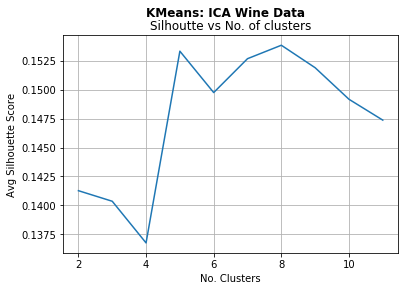

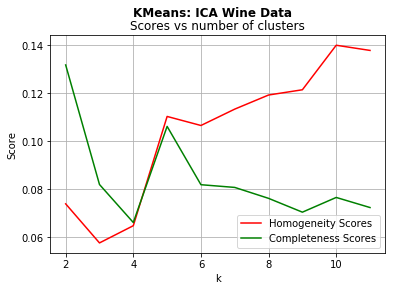

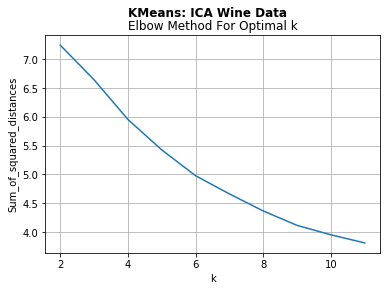

[0.040836290898712435, 0.04943728627529166, 0.05369456914467724, 0.050693132848886935, 0.05334884319628609, 0.05144482662108189, 0.04699147964762222, 0.05329857775767392, 0.05018880041299215, 0.05101165691245122]


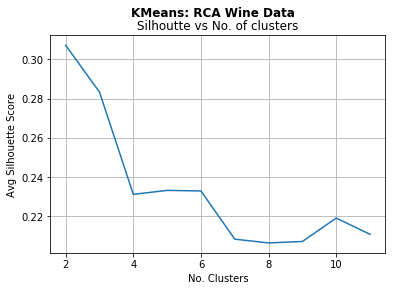

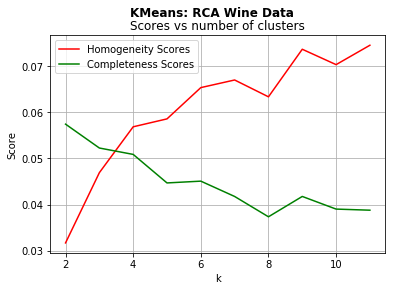

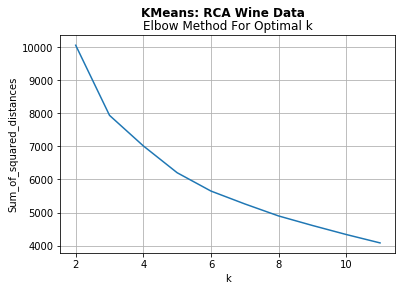

[0.03856644493936331, 0.03670230823739403, 0.04206785340057166, 0.03911582418961599, 0.04482030954004766, 0.0431479524752263, 0.04235911729588301, 0.04220266329311514, 0.04244498301039581, 0.04241545408312521]


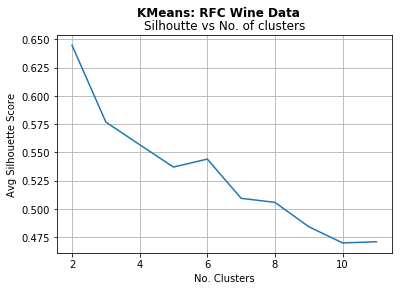

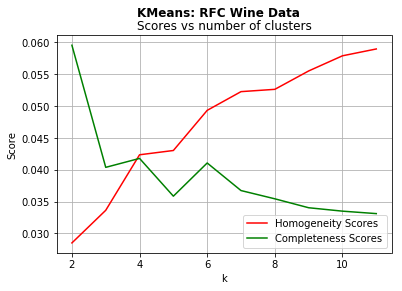

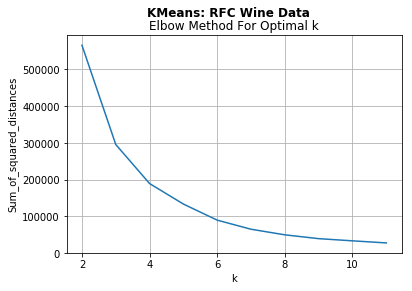

In [137]:
# K means 
run_kmeans(pca_wine,Y2,n =12, title='KMean: PCA Wine Data', file= "Kmeans_pca_W" )
run_kmeans(ica_wine,Y2,n =12,title='KMeans: ICA Wine Data', file= "Kmeans_ica_W")
run_kmeans(rca_wine,Y2,n =12,title='KMeans: RCA Wine Data', file= "Kmeans_rca_W")
run_kmeans(rfc_wine,Y2,n =12,title='KMeans: RFC Wine Data', file= "Kmeans_rfc_W")

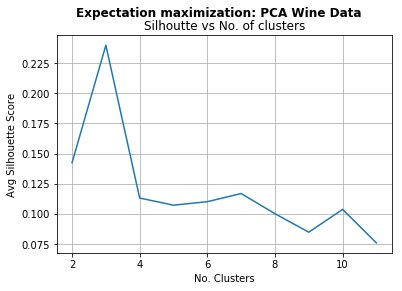

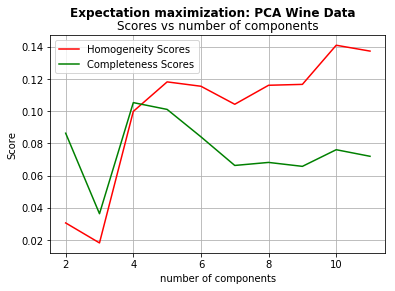

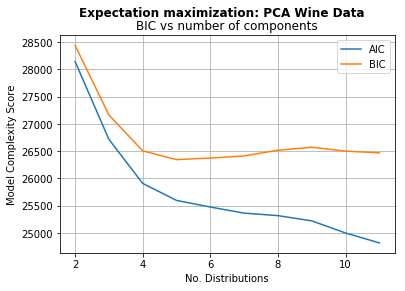

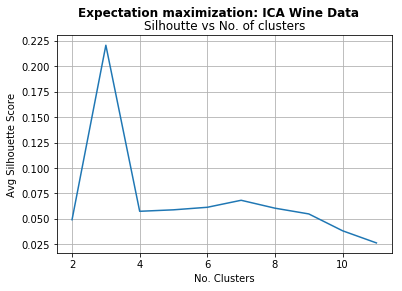

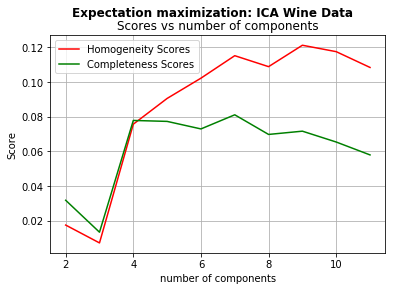

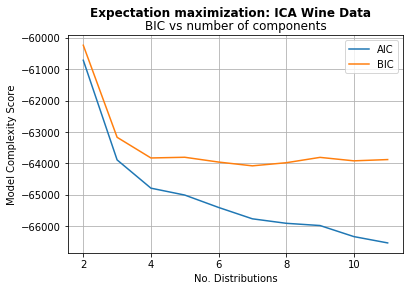

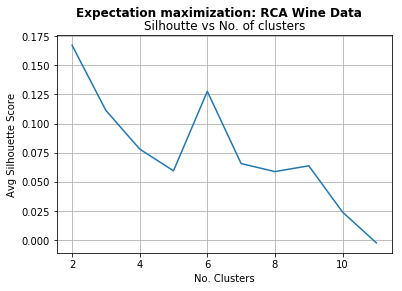

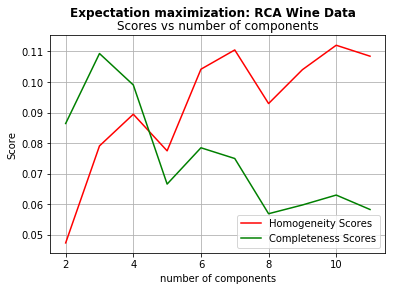

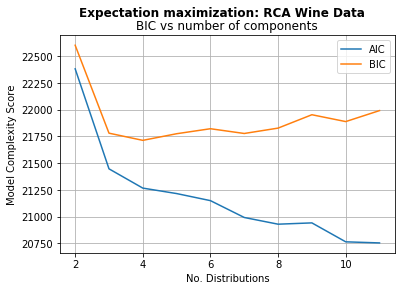

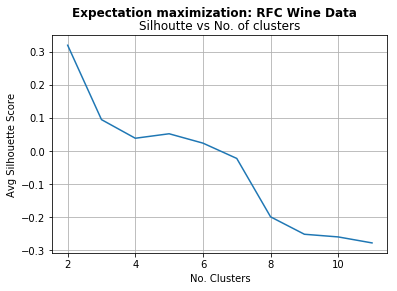

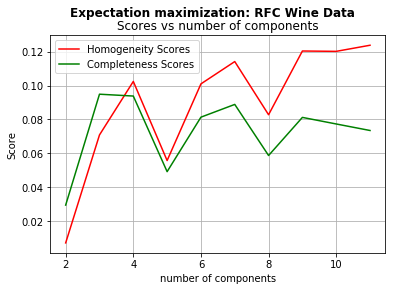

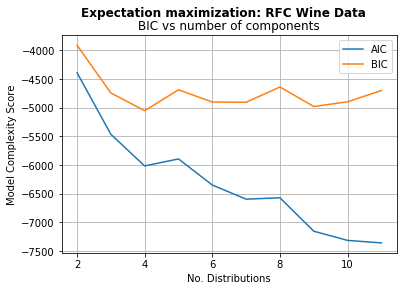

In [138]:
# Expectation maximization
run_EM(pca_wine,Y2,n =12,title='Expectation maximization: PCA Wine Data', file= "EM_pca_W")
run_EM(ica_wine,Y2,n =12,title='Expectation maximization: ICA Wine Data', file= "EM_ica_W")
run_EM(rca_wine,Y2,n =12,title='Expectation maximization: RCA Wine Data', file= "EM_rca_W")
run_EM(rfc_wine,Y2,n =12,title='Expectation maximization: RFC Wine Data', file= "EM_rfc_W")

# Neural Networks

In [165]:
def classifier_evaluation(clf,X_train, X_test, y_train, y_test, title=''):    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    
    accuracy = accuracy_score(y_test,y_pred)

    print("Model Evaluation Metrics "+title+" Test Dataset")
    print("*****************************************************")    
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("*****************************************************")
    plt.figure()
    plt.show()
    return accuracy, training_time, pred_time

def add_clusters(x1, isKM = True):
    df = pd.DataFrame(x1)
    print('x shape ', x1.shape)
    if isKM:
        km = KMeans(n_clusters=4,n_init=10,random_state=20,n_jobs=-1).fit(x1)
        df['KM'] = km.labels_
    else:
        em = EM(n_components=3,covariance_type='full',n_init=1,warm_start=False,random_state=20).fit(x1)
        df['EM'] = em.predict(x1)
    clustered_data = np.array(df)
    return clustered_data

In [166]:
accuracy= []; training_time=[]; pred_time=[]

nn = MLPClassifier(hidden_layer_sizes=(5,5), activation='identity', solver='lbfgs', alpha=0.5, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.1, power_t=0.5, 
                        max_iter=3000, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=False, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)


a,  tt, pt = classifier_evaluation(nn,X2_train, X2_test, Y2_train, Y2_test, "Neural Networks")

accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks Test Dataset
*****************************************************
Accuracy:  0.63
Model Training Time (s):   0.15751
Model Prediction Time (s): 0.00019

*****************************************************


<Figure size 432x288 with 0 Axes>

In [167]:
X1pca_train, X1pca_test, Y1pca_train, Y1pca_test = train_test_split(np.array(pca_wine),np.array(Y2), test_size=0.20, random_state =0)

a, tt, pt = classifier_evaluation(nn,X1pca_train, X1pca_test, Y1pca_train, Y1pca_test, "Neural Networks with PCA")

accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with PCA Test Dataset
*****************************************************
Accuracy:  0.62
Model Training Time (s):   0.15722
Model Prediction Time (s): 0.00021

*****************************************************


<Figure size 432x288 with 0 Axes>

In [168]:
X1ica_train, X1ica_test, Y1ica_train, Y1ica_test = train_test_split(np.array(ica_wine),np.array(Y2), test_size=0.20, random_state =0)

a, tt, pt = classifier_evaluation(nn,X1ica_train, X1ica_test, Y1ica_train, Y1ica_test, "Neural Networks with ICA")

accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with ICA Test Dataset
*****************************************************
Accuracy:  0.61
Model Training Time (s):   0.42124
Model Prediction Time (s): 0.00020

*****************************************************


<Figure size 432x288 with 0 Axes>

In [169]:
X1rca_train, X1rca_test, Y1rca_train, Y1rca_test = train_test_split(np.array(rca_wine),np.array(Y2), test_size=0.20, random_state =0)

a, tt, pt = classifier_evaluation(nn,X1rca_train, X1rca_test, Y1rca_train, Y1rca_test, "Neural Networks with RCA")

accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with RCA Test Dataset
*****************************************************
Accuracy:  0.60
Model Training Time (s):   0.15595
Model Prediction Time (s): 0.00024

*****************************************************


<Figure size 432x288 with 0 Axes>

In [170]:
X1rfc_train, X1rfc_test, Y1rfc_train, Y1rfc_test = train_test_split(np.array(rfc_wine),np.array(Y2), test_size=0.20, random_state =0)

a, tt, pt = classifier_evaluation(nn,X1rfc_train, X1rfc_test, Y1rfc_train, Y1rfc_test, "Neural Networks with RFC")

accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with RFC Test Dataset
*****************************************************
Accuracy:  0.62
Model Training Time (s):   1.71715
Model Prediction Time (s): 0.00020

*****************************************************


<Figure size 432x288 with 0 Axes>

In [171]:
NN_kmeans = add_clusters(X2,isKM = True)
X1kmeans_train, X1kmeans_test, Y1kmeans_train, Y1kmeans_test = train_test_split(np.array(NN_kmeans),np.array(Y2), test_size=0.20, random_state =0)
a, tt, pt = classifier_evaluation(nn,X1kmeans_train, X1kmeans_test, Y1kmeans_train, Y1kmeans_test, "Neural Networks with Kmeans")
accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

x shape  (1599, 11)
Model Evaluation Metrics Neural Networks with Kmeans Test Dataset
*****************************************************
Accuracy:  0.62
Model Training Time (s):   0.15262
Model Prediction Time (s): 0.00025

*****************************************************


<Figure size 432x288 with 0 Axes>

In [172]:
NN_EM = add_clusters(X2,isKM = False)
X1EM_train, X1EM_test, Y1EM_train, Y1EM_test = train_test_split(np.array(NN_EM),np.array(Y2), test_size=0.20, random_state =0)
a, tt, pt = classifier_evaluation(nn,X1EM_train, X1EM_test, Y1EM_train, Y1EM_test, "Neural Networks with Kmeans")
accuracy.append(a)
training_time.append(tt)
pred_time.append(pt)

x shape  (1599, 11)
Model Evaluation Metrics Neural Networks with Kmeans Test Dataset
*****************************************************
Accuracy:  0.61
Model Training Time (s):   0.17536
Model Prediction Time (s): 0.00032

*****************************************************


<Figure size 432x288 with 0 Axes>

In [173]:
df= pd.DataFrame(accuracy, columns = ['Accuracy'], index = ['NN', 'NN-PCA', 'NN-ICA', 'NN-RCA', 'NN-RFC','NN-Kmeans', 'NN-EM'])
df['Training time'] = training_time
df['Test time'] = pred_time
df.round(4)
df

Accuracy  Training time  Test time
NN         0.634375       0.157507   0.000194
NN-PCA     0.615625       0.157222   0.000206
NN-ICA     0.612500       0.421243   0.000202
NN-RCA     0.603125       0.155952   0.000243
NN-RFC     0.625000       1.717154   0.000196
NN-Kmeans  0.621875       0.152618   0.000250
NN-EM      0.612500       0.175359   0.000320

In [174]:
classifiers = ('NN', 'NN-PCA', 'NN-ICA', 'NN-RCA', 'NN-RFC','NN-Kmeans', 'NN-EM')
x_label = np.arange(len(classifiers))

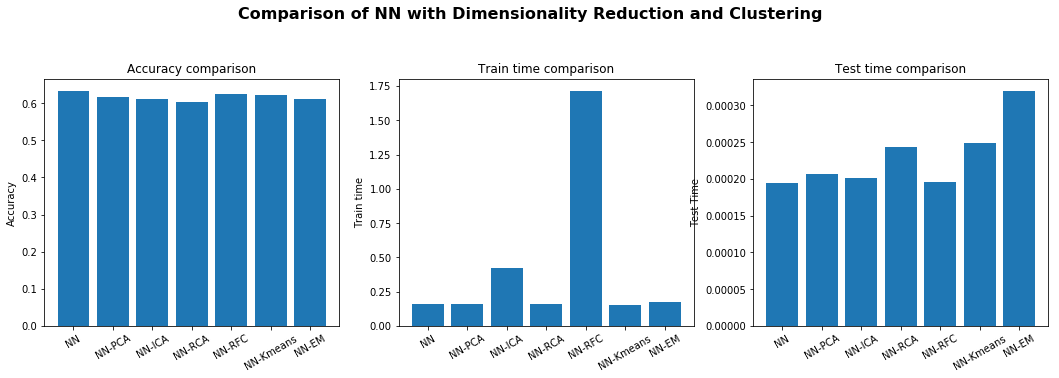

In [176]:
plt.figure(figsize=(18, 10))
w=0.8
#plt.figure()
plt.subplot(231)
# ax = plt.subplot(231)
# ax.bar(x_label-w, accuracy, width=w, label = "Accuracy")
# ax.bar(x_label, f1, width=w, color = '#73C2FB', label = "F1")
# ax.set_xticks(x_label - w/2)
# ax.legend()
plt.suptitle('Comparison of NN with Dimensionality Reduction and Clustering', fontsize=16, fontweight='bold')
plt.bar(x_label, accuracy, w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
#plt.gca().set_ylim(0.3, 1)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')

plt.subplot(232)
plt.bar(x_label, training_time,w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.title('Train time comparison')
plt.ylabel('Train time')

plt.subplot(233)
plt.bar(x_label, pred_time,w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
#plt.gca().set_ylim(0.00008, 0.00016)
plt.title('Test time comparison')
plt.ylabel('Test Time')

plt.show()

